### Cloning my Git Repo

In [ ]:
!git clone https://github.com/Jawakar-7/Image-Classification-using-multiple-models-.git

### Import the necessary files:

In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.models import Sequential
from keras.layers import Activation , BatchNormalization , Dense , Dropout , Flatten , MaxPooling2D,Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from  keras.models import Sequential

In [12]:
test_path='/content/Image-Classification-using-multiple-models-/Datasets/seg_test/seg_test'
train_path='/content/Image-Classification-using-multiple-models-/Datasets/seg_train/seg_train'

### Image data Generator
It is a library available in keras.preprocessing to extract images from class files and accordingly set class names for them (we need the images to be in a seperate class files for this function to work)
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

This is an effective way of accessing images instead of using the os package to parse through all the files one by one.

In [13]:
from sklearn.utils import column_or_1d
train_xgen=ImageDataGenerator(
    rescale=1.0/255,#Scaling Down the data
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.1,
)
X_train=train_xgen.flow_from_directory(
    train_path,
    target_size=(150,150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

Found 14034 images belonging to 6 classes.


In [14]:
test_xgen=ImageDataGenerator(
    rescale=1.0/255
)
X_test=test_xgen.flow_from_directory(
    test_path,
    class_mode='categorical',
    target_size=(150,150),
    batch_size=32,
    color_mode='rgb',
)

Found 3000 images belonging to 6 classes.


The output of ImageDataGenerator is a Generator object.

In [21]:
labels={i:k for k,i in X_train.class_indices.items()}
for i,k in labels.items():
  print(f"{i}:{k}")

0:buildings
1:forest
2:glacier
3:mountain
4:sea
5:street


### Now that we have all our images in seperate classes we will try to visualize them using matplotlib

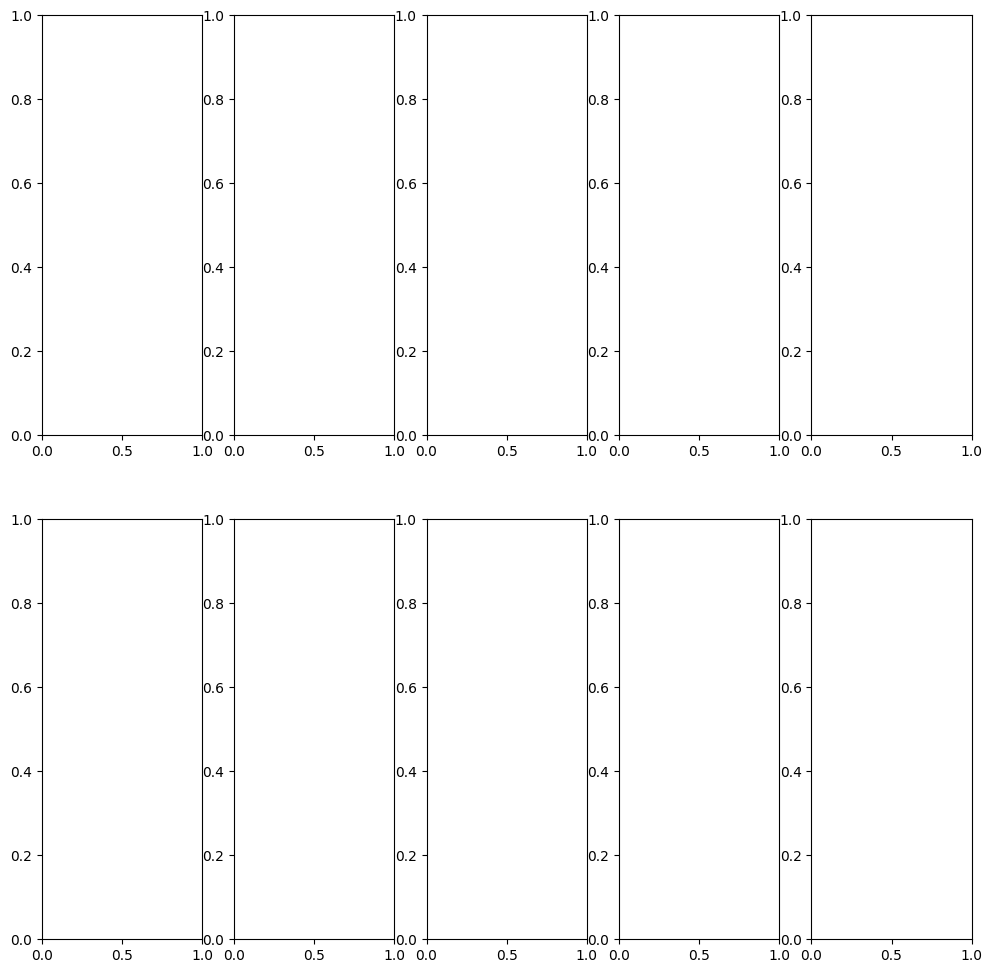

In [26]:
fig , ax=plt.subplots(ncols=5,nrows=2,figsize=(12,12))
t=0
for a in range(2):
    for  b in range(5):
